# Set Parameter
- Attention = False
- Drop out = 0.2
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Hidden unit = 50
- Batch size = 32
- Pretrain Epochs = 20
- Train Epochs = 20

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Pretrain - Data load

In [3]:
pretrain_train_path = "data/grammar_data_N50_train.txt"
pretrain_dev_path = "data/grammar_data_N50_test.txt"

# Train - Data load

In [4]:
train_path = "data/grammar_data_N100_train.txt"
dev_path = "data/grammar_data_N100_test.txt"

# Pretrain - Prepare dataset

In [5]:
pretrain_src = fields.SourceField()
pretrain_tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
pretrain_train = torchtext.data.TabularDataset(
    path=pretrain_train_path, format='tsv',
    fields=[('src', pretrain_src), ('tgt', pretrain_tgt)],
    filter_pred=len_filter
)
pretrain_dev = torchtext.data.TabularDataset(
    path=pretrain_dev_path, format='tsv',
    fields=[('src', pretrain_src), ('tgt', pretrain_tgt)],
    filter_pred=len_filter
)
pretrain_src.build_vocab(pretrain_train)
pretrain_tgt.build_vocab(pretrain_train)
pretrain_input_vocab = pretrain_src.vocab
pretrain_output_vocab = pretrain_tgt.vocab

# Train - Prepare dataset

In [6]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Pretrain - Prepare loss

In [7]:
pretrain_weight = torch.ones(len(pretrain_tgt.vocab))
pretrain_pad = pretrain_tgt.vocab.stoi[pretrain_tgt.pad_token]
pretrain_loss = Perplexity(pretrain_weight, pretrain_pad)
if torch.cuda.is_available():
    pretrain_loss.cuda()

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Train - Prepare loss

In [8]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

# Variable definition

In [9]:
seq2seq = None
optimizer = "Adam"

hidden_sizes = list(range(50, 51, 4))
print(hidden_sizes)
error_rate = []
accuracy = []
losses = []

[50]


# Initialize model

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-02-01 17:57:21,382 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Hidden size is 50
6
49
6
49
pretrain..


2019-02-01 17:59:55,452 INFO   Finished epoch 1: Train loss: 7.0897, Dev loss: 3.0041, Accuracy(Character): 0.5637, Accuracy(Word): 0.0000
2019-02-01 18:02:29,821 INFO   Finished epoch 2: Train loss: 2.2310, Dev loss: 2.2422, Accuracy(Character): 0.6672, Accuracy(Word): 0.0000
2019-02-01 18:05:05,039 INFO   Finished epoch 3: Train loss: 1.9113, Dev loss: 1.9609, Accuracy(Character): 0.7252, Accuracy(Word): 0.0001
2019-02-01 18:07:41,873 INFO   Finished epoch 4: Train loss: 1.7753, Dev loss: 1.9574, Accuracy(Character): 0.7171, Accuracy(Word): 0.0006
2019-02-01 18:10:17,320 INFO   Finished epoch 5: Train loss: 1.6310, Dev loss: 1.7465, Accuracy(Character): 0.7710, Accuracy(Word): 0.0002
2019-02-01 18:12:52,431 INFO   Finished epoch 6: Train loss: 1.5835, Dev loss: 1.6492, Accuracy(Character): 0.7894, Accuracy(Word): 0.0035
2019-02-01 18:15:26,053 INFO   Finished epoch 7: Train loss: 1.5011, Dev loss: 1.6983, Accuracy(Character): 0.7855, Accuracy(Word): 0.0035
2019-02-01 18:17:58,866 INF

train..


2019-02-01 18:53:34,633 INFO   Finished epoch 1: Train loss: 1126887.5207, Dev loss: 3.7097, Accuracy(Character): 0.5066, Accuracy(Word): 0.0000
2019-02-01 18:58:13,793 INFO   Finished epoch 2: Train loss: 2.4414, Dev loss: 3.3215, Accuracy(Character): 0.5609, Accuracy(Word): 0.0000
2019-02-01 19:02:57,263 INFO   Finished epoch 3: Train loss: 2.1932, Dev loss: 2.5930, Accuracy(Character): 0.6222, Accuracy(Word): 0.0000
2019-02-01 19:07:42,895 INFO   Finished epoch 4: Train loss: 2.0646, Dev loss: 2.6039, Accuracy(Character): 0.6252, Accuracy(Word): 0.0000
2019-02-01 19:12:27,176 INFO   Finished epoch 5: Train loss: 1.9324, Dev loss: 2.1977, Accuracy(Character): 0.6748, Accuracy(Word): 0.0000
2019-02-01 19:17:11,304 INFO   Finished epoch 6: Train loss: 1.8648, Dev loss: 2.5522, Accuracy(Character): 0.6408, Accuracy(Word): 0.0000
2019-02-01 19:21:53,131 INFO   Finished epoch 7: Train loss: 1.8137, Dev loss: 2.0876, Accuracy(Character): 0.6941, Accuracy(Word): 0.0000
2019-02-01 19:26:35,4

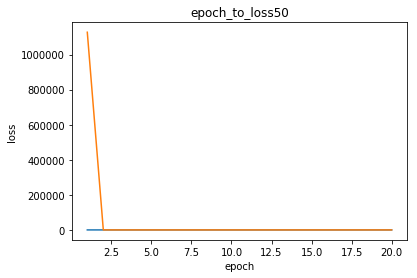

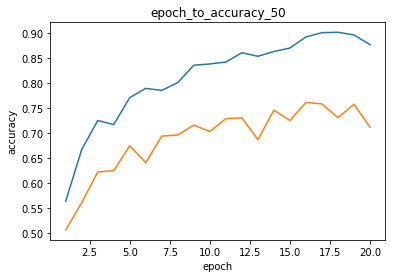

In [10]:
for i in hidden_sizes:
    print("Hidden size is %d" % i)
    hidden_size = i
    bidirectional = True
    print(len(pretrain_src.vocab))
    print(len(pretrain_tgt.vocab))
    print(len(src.vocab))
    print(len(tgt.vocab))
    encoder = EncoderRNN(len(pretrain_src.vocab), max_len, hidden_size,
                        bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(pretrain_tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                        dropout_p=0.2, use_attention=False, bidirectional=bidirectional,
                        eos_id=pretrain_tgt.eos_id, sos_id=pretrain_tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = SupervisedTrainer(loss=pretrain_loss, batch_size=32,
                        checkpoint_every=50,
                        print_every=100,
                        hidden_size=hidden_size,
                        fig_path="log/plot/pretrained_no_att")
    print("pretrain..")

    seq2seq, ave_loss, character_accuracy = t.train(seq2seq, pretrain_train,
                                                    num_epochs=20, dev_data=pretrain_dev,
                                                    optimizer=optimizer,
                                                    teacher_forcing_ratio=0.5)
    
    print("train..")
    seq2seq, ave_loss, character_accuracy = t.train(seq2seq, train,
                                                    num_epochs=20, dev_data=dev,
                                                    optimizer=optimizer,
                                                    teacher_forcing_ratio=0.5)

    losses.append(ave_loss/100)
    error_rate.append(1 - character_accuracy)
    accuracy.append(character_accuracy)

In [11]:
torch.save(seq2seq.state_dict(), 'log/pretrained_no_att_model_save.pth')